# Data Preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_sales = pd.read_csv('sales.csv')
df_sales.head(10)

,order_id,customer_name,order_date,category,sub_category,price,region,city,qty
0,OD1,Harish,2017-11-08,Oil & Masala,Masalas,852.72,North,Vellore,341
1,OD2,Sudha,2017-11-08,Beverages,Health Drinks,599.20,South,Krishnagiri,120
2,OD3,Hussain,2017-06-12,Food Grains,Atta & Flour,2194.80,West,Perambalur,189
3,OD4,Jackson,2016-10-11,Fruits & Veggies,Fresh Vegetables,806.40,South,Dharmapuri,584
4,OD5,Ridhesh,2016-10-11,Food Grains,Organic Staples,1436.55,South,Ooty,82
5,OD6,Adavan,2015-06-09,Food Grains,Organic Staples,1982.30,West,Dharmapuri,103
6,OD7,Jonas,2015-06-09,Fruits & Veggies,Fresh Vegetables,479.08,West,Trichy,588
7,OD8,Hafiz,2015-06-09,Fruits & Veggies,Fresh Fruits,1699.24,West,Ramanadhapuram,828
8,OD9,Hafiz,2015-06-09,Bakery,Biscuits,609.07,West,Tirunelveli,877
9,OD10,Krithika,2015-06-09,Bakery,Cakes,1310.35,West,Chennai,663


In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       9994 non-null   object 
 1   customer_name  9994 non-null   object 
 2   order_date     9994 non-null   object 
 3   category       9994 non-null   object 
 4   sub_category   9994 non-null   object 
 5   price          9994 non-null   float64
 6   region         9994 non-null   object 
 7   city           9994 non-null   object 
 8   qty            9994 non-null   int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 702.8+ KB


In [4]:
df_sales.describe()

,price,qty
count,9994.000000,9994.000000
mean,1121.659075,500.908745
std,472.619706,290.386917
min,275.000000,1.000000
25%,724.910000,245.000000
50%,1095.765000,499.000000
75%,1458.405000,754.000000
max,2367.400000,999.000000


## Data Cleansing

In [5]:
df_sales.isnull().sum()

order_id         0
customer_name    0
order_date       0
category         0
sub_category     0
price            0
region           0
city             0
qty              0
dtype: int64

In [6]:
df_sales.duplicated().sum()

0

## Feature Selection

### Recency

In [7]:
import datetime

# Convert 'order_date' to datetime
df_sales['order_date'] = pd.to_datetime(df_sales['order_date'])

present_day = df_sales['order_date'].max()+ datetime.timedelta(days=2)

print("Present day: ",present_day)

recency = df_sales.groupby('customer_name').agg({'order_date': lambda date: (present_day - date.max()).days
                                        }).reset_index()

recency = recency.rename(columns={"order_date": "recency"})
recency.head()

Present day:  2019-01-01 00:00:00


,customer_name,recency
0,Adavan,9
1,Aditi,3
2,Akash,4
3,Alan,8
4,Amrish,5


### Frequency & Monetary

In [8]:
dataset = df_sales.groupby(['customer_name']).agg({
                                    'order_id' : ['count'],
                                    'price' : ['sum']
}).reset_index()
dataset.columns = ['customer_name','frequency','monetary']
dataset.head()

,customer_name,frequency,monetary
0,Adavan,205,237296.71
1,Aditi,187,221234.95
2,Akash,196,225366.74
3,Alan,198,219986.77
4,Amrish,227,253159.11


In [9]:
dataset = dataset.merge(recency, on='customer_name', how='inner')
dataset.head()

,customer_name,frequency,monetary,recency
0,Adavan,205,237296.71,9
1,Aditi,187,221234.95,3
2,Akash,196,225366.74,4
3,Alan,198,219986.77,8
4,Amrish,227,253159.11,5


In [10]:
dataset.isnull().sum()

customer_name    0
frequency        0
monetary         0
recency          0
dtype: int64

In [11]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customer_name  50 non-null     object 
 1   frequency      50 non-null     int64  
 2   monetary       50 non-null     float64
 3   recency        50 non-null     int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 2.0+ KB


## Outlier Handling

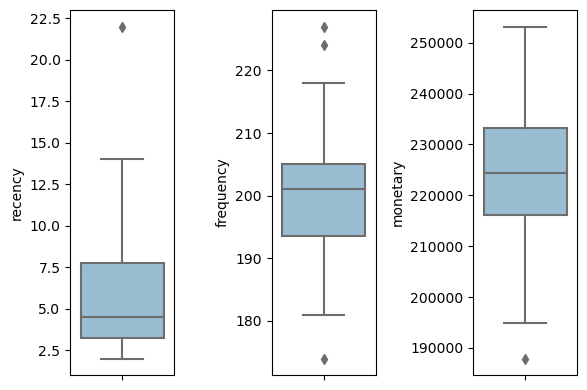

In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns

feature=['recency','frequency','monetary']

plt.figure(figsize=(10, 4))
for i in range(0, len(feature)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=dataset[feature[i]], color='#91bfdb', orient='v')
    plt.tight_layout()

In [13]:
print(f'Jumlah Baris Sebelum Outlier Dihapus: {len(dataset)}')
filtered_entries = np.array([True] * len(dataset))
for col in['recency','frequency','monetary']:
    
    q1=dataset[col].quantile(0.25)
    q3=dataset[col].quantile(0.75)
    iqr=q3-q1

    min_IQR = q1 - (1.5 * iqr)
    max_IQR = q3 + (1.5 * iqr)

    filtered_entries=((dataset[col]>=min_IQR) & (dataset[col]<=max_IQR)) & filtered_entries
    dataset=dataset[filtered_entries]

print(f'Jumlah Baris Sebelum Outlier Dihapus: {len(dataset)}')

Jumlah Baris Sebelum Outlier Dihapus: 50
Jumlah Baris Sebelum Outlier Dihapus: 46


C:\Users\Acer\AppData\Local\Temp\ipykernel_15440\3989400902.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset=dataset[filtered_entries]
C:\Users\Acer\AppData\Local\Temp\ipykernel_15440\3989400902.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dataset=dataset[filtered_entries]


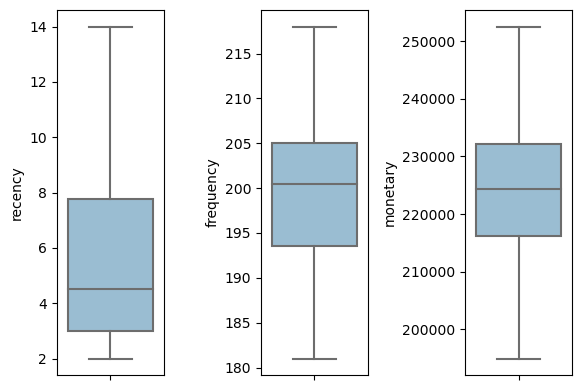

In [14]:
plt.figure(figsize=(10, 4))
for i in range(0, len(feature)):
    plt.subplot(1, 5, i+1)
    sns.boxplot(y=dataset[feature[i]], color='#91bfdb', orient='v')
    plt.tight_layout()

## Data Scaler

In [15]:
# Standardisasi menggunakan StandardScaler
features=['recency','frequency','monetary']
X = dataset[features].values

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data = X_std, columns = features)

## Feature Distribution

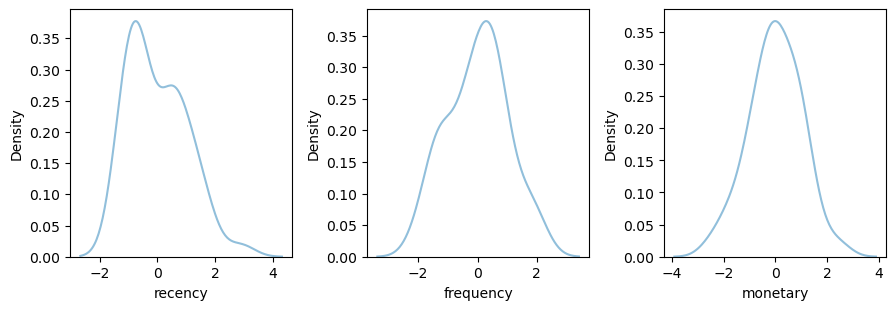

In [16]:
# melihat distribusi data yang telah dilakukan standardisasi
plt.figure(figsize=(15, 15))
for i in range(0, len(features)):
    plt.subplot(5, 5, i+1)
    sns.kdeplot(df_std[features[i]], color='#91bfdb')
    plt.xlabel(features[i])
    plt.tight_layout()

## Find K Value

In [17]:
# mencari nilai k optimal dengan parameter inertia
from sklearn.cluster import KMeans

inertia = []
k_values = range(2,11)

# fit model
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(df_std)
    inertia.append(kmeans.inertia_)

## Elbow Method & Silhouette Score

Text(0, 0.5, 'Inertia')

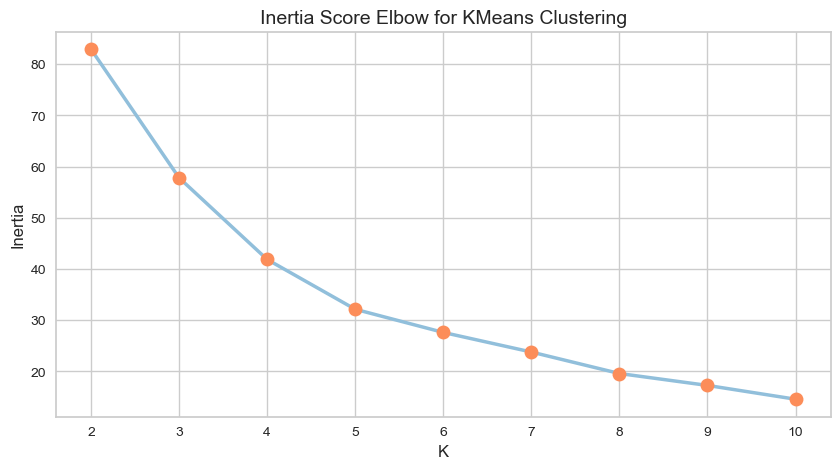

In [18]:
# Visualisasi grafik elbow method
from yellowbrick.cluster import KElbowVisualizer
plt.figure(figsize=(10, 5))

# plot grafik
plt.plot(k_values, inertia ,color='#91bfdb', linewidth= 2.5, marker='o', markerfacecolor='#fc8d59', markersize=10)
plt.title('Inertia Score Elbow for KMeans Clustering', fontsize=14)
plt.xlabel('K',fontsize=12)
plt.ylabel('Inertia',fontsize=12)

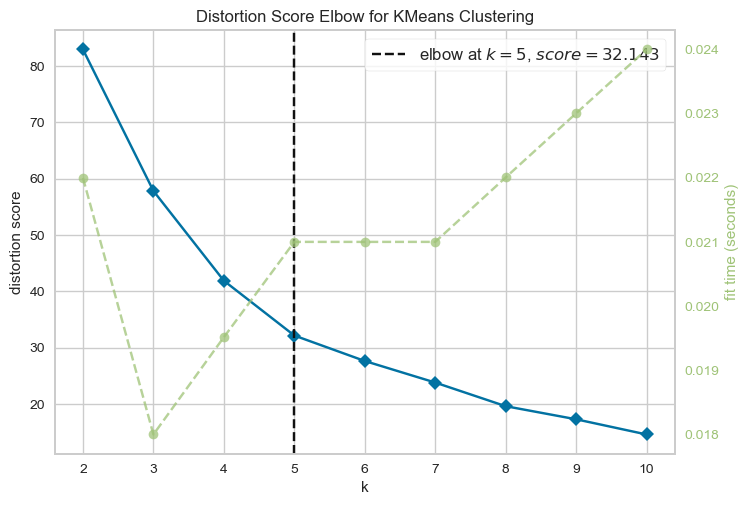

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# visualisasi innertia vs k dengan parameter distortion
from yellowbrick.cluster import KElbowVisualizer

# fit model
model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,11), metric='distortion', timings=True, locate_elbow=True)
visualizer.fit(df_std)       
visualizer.show() 

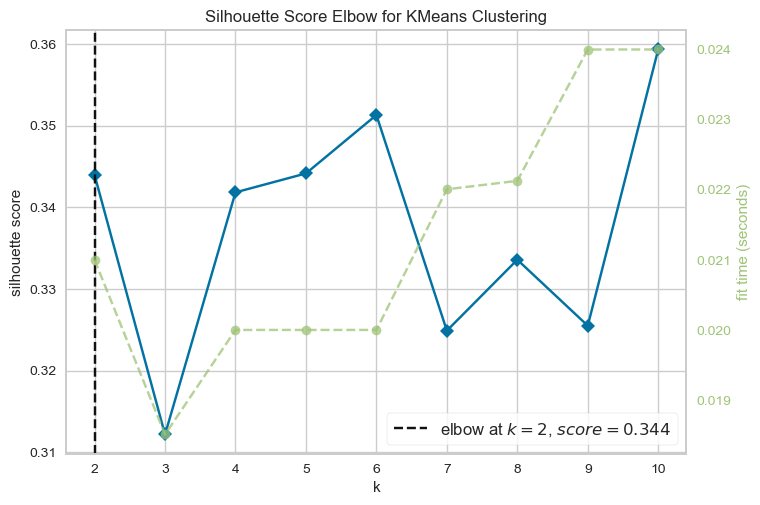

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [20]:

from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(2,11), metric='silhouette', timings=True, locate_elbow=True)
visualizer.fit(df_std)        
visualizer.show()  

## K-Means Building

In [21]:
from sklearn.cluster import KMeans

# fit model
kmeans = KMeans(n_clusters=6, random_state = 123)
kmeans.fit(df_std.values)
df_std['cluster'] = kmeans.labels_

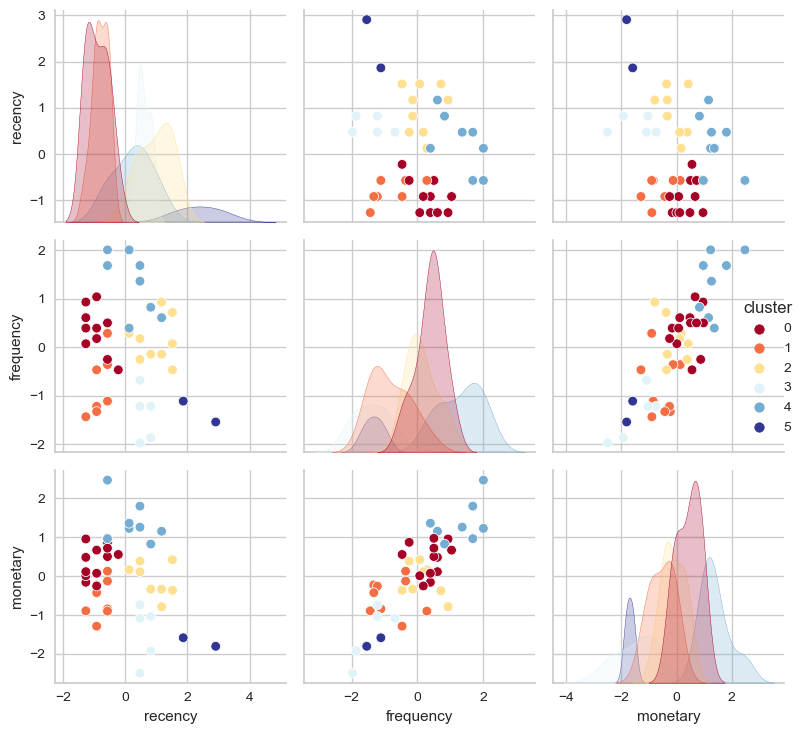

In [22]:
# visualisasi dengan pairplot
sns.pairplot(data=df_std, hue='cluster', diag_kind='kde', palette='RdYlBu')
plt.tight_layout()

In [23]:
## melakukan PCA untuk melihat visualisasi
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)

pca.fit(df_std)
pcs = pca.transform(df_std)


df_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
df_pca['cluster'] = df_std['cluster']
df_pca

,PC 1,PC 2,cluster
0,2.327303,1.450033,4
1,-1.085558,-1.101533,1
2,-0.989685,-0.228846,1
3,0.582796,-0.399425,2
4,-0.966399,-0.405031,1
5,-1.187363,-1.592249,1
6,1.764686,2.598138,4
7,-2.198772,0.009140,0
8,-0.871118,-1.420915,1
9,1.377623,-1.075323,3


## Segmentation

Text(0.5, 1.0, 'Customer Segmentation Based on RFM Model')

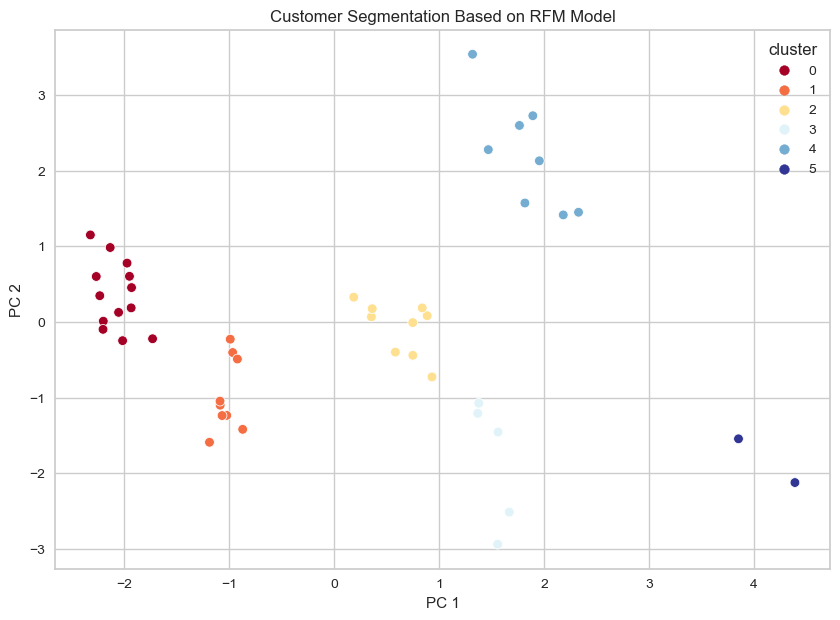

In [24]:
# visualisasi hasi segmentasi
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df_pca, x="PC 1", y="PC 2", hue="cluster", palette='RdYlBu')
plt.title('Customer Segmentation Based on RFM Model')

In [25]:
# menambahkan cluster ke dataframe
dataset['cluster'] = kmeans.labels_
display(dataset.groupby('cluster').agg(['mean','median','min','max']))

C:\Users\Acer\AppData\Local\Temp\ipykernel_15440\1989982649.py:3: FutureWarning: ['customer_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(dataset.groupby('cluster').agg(['mean','median','min','max']))


frequency                        monetary                         \
               mean median  min  max           mean      median        min   
cluster                                                                      
0        202.923077  204.0  195  209  228804.905385  229720.510  220935.13   
1        191.777778  189.0  186  202  217633.156667  218922.250  208917.96   
2        200.555556  200.0  195  208  222438.696667  219991.810  214731.17   
3        186.400000  188.0  181  193  206953.264000  211254.110  194891.15   
4        211.625000  213.5  203  218  239946.142500  238334.860  233468.22   
5        187.000000  187.0  185  189  204173.115000  204173.115  202897.66   

                      recency                 
               max       mean median min max  
cluster                                       
0        235173.65   3.076923    3.0   2   5  
1        225366.74   3.333333    3.0   2   4  
2        228775.69   8.444444    9.0   6  10  
3        215268.04   7.400000    7.0   7   8  
4        252568.47   6.375000    6.5   4   9  
5        205448.57  12.500000   12.5  11  14

## Segmentation Analysis

In [26]:
# persentase customer setiap cluster
cluster_count = dataset['cluster'].value_counts().reset_index()
cluster_count.columns = ['cluster', 'count']
cluster_count['percentage (%)'] = round((cluster_count['count']/len(df_std))*100,2)
cluster_count = cluster_count.sort_values(by=['cluster']).reset_index(drop=True)
cluster_count

,cluster,count,percentage (%)
0,0,13,28.26
1,1,9,19.57
2,2,9,19.57
3,3,5,10.87
4,4,8,17.39
5,5,2,4.35


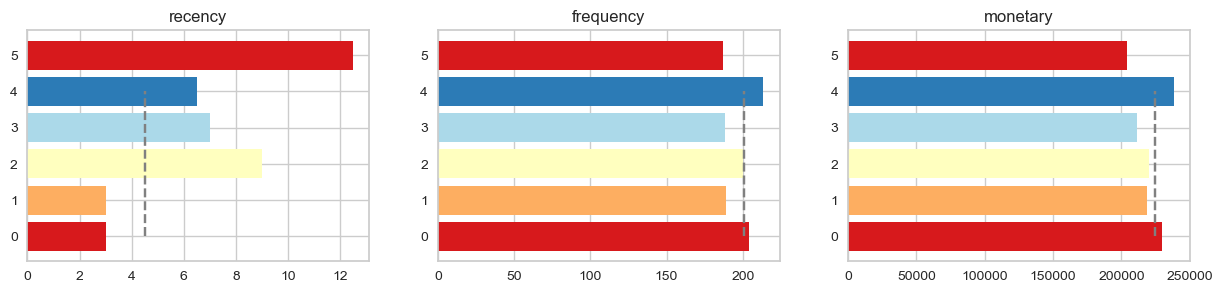

In [28]:
# melihat rata-rata variabel RFM antar cluster
feature=['recency','frequency','monetary']
c = ["#d7191c","#fdae61","#ffffbf","#abd9e9","#2c7bb6"]

def dist_list(lst):
    plt.figure(figsize=[len(lst)*5,3])
    i = 1
    for col in lst:
        ax = plt.subplot(1,len(lst),i)
        ax.vlines(dataset[col].median(), ymin=0, ymax=4, color='grey', linestyle='--')
        g = dataset.groupby('cluster')
        x = g[col].median().index
        y = g[col].median().values
        ax.barh(x,y, color=c) 
        plt.title(col)
        i = i+1

        
dist_list(feature)

In [30]:
display(dataset.groupby('cluster').agg(['mean','min','max']))

C:\Users\Acer\AppData\Local\Temp\ipykernel_15440\2245385552.py:1: FutureWarning: ['customer_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  display(dataset.groupby('cluster').agg(['mean','min','max']))


frequency                 monetary                          recency  \
               mean  min  max           mean        min        max       mean   
cluster                                                                         
0        202.923077  195  209  228804.905385  220935.13  235173.65   3.076923   
1        191.777778  186  202  217633.156667  208917.96  225366.74   3.333333   
2        200.555556  195  208  222438.696667  214731.17  228775.69   8.444444   
3        186.400000  181  193  206953.264000  194891.15  215268.04   7.400000   
4        211.625000  203  218  239946.142500  233468.22  252568.47   6.375000   
5        187.000000  185  189  204173.115000  202897.66  205448.57  12.500000   

                 
        min max  
cluster          
0         2   5  
1         2   4  
2         6  10  
3         7   8  
4         4   9  
5        11  14